# Importing Stuff

In [1]:
from comet_ml import start
from comet_ml.integration.pytorch import log_model
from comet_ml.integration.pytorch import watch
import comet_ml

In [2]:
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import PIL
import torch.optim as optim

In [3]:
## Checking the CUDA
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available!
Current GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Loading The Data

In [4]:

data_dir = '/root/cw2_fold/Data/images_original'


train_transforms = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.ToTensor(),
])



full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 15% for testing


train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for images, labels in train_loader:
    print(images.shape, labels)
    break

torch.Size([32, 3, 180, 180]) tensor([3, 5, 2, 9, 8, 0, 6, 4, 3, 7, 3, 8, 2, 7, 1, 6, 3, 1, 3, 3, 4, 5, 5, 9,
        8, 6, 7, 1, 1, 5, 2, 9])


## FCN Model

In [5]:
input_size=180*180*3
hidden_size1=64
hidden_size2=32
output_size=10

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1=nn.Linear(input_size,hidden_size1)
    self.layer2=nn.Linear(hidden_size1,hidden_size2)
    self.layer3=nn.Linear(hidden_size2,output_size)
    self.relu=nn.ReLU()
  def forward(self,x):
    x=x.flatten(start_dim=1)
    #print (x.size())
    x=self.layer1(x)
    x=self.relu(x)
    x=self.layer2(x)
    x=self.relu(x)
    x=self.layer3(x)

    return x

In [6]:
experiment_fcn = start(
  api_key="dEZzsaQExxOoLg04pynbidvNw",
  project_name="Deep Learning Technologies",
  workspace="gibranfil"
)

experiment_fcn.set_name ("FCN")
hyper_param_fcn = {'learning_rate' : 0.01, 'epochs' : 50}
experiment_fcn.log_parameters (hyper_param_fcn)
model_fcn = Net()
loss_fn=nn.CrossEntropyLoss()
running_loss=0.0



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gibranfil/deep-learning-technologies/a0f6c47c9879436bbfc94c4437679b4d

COMET INFO: Couldn't find a Git repository in '/root/cw2_fold' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [7]:
import torch
from sklearn.metrics import accuracy_score



def train (model,experiment,hyper) :
    optimizer=optim.SGD(model.parameters(),lr=hyper['learning_rate'])
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = [] 
    for epoch in range(hyper['epochs']):
        model.cuda()
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_accuracy = 0.0

        # Training loop
        for imgs, labels in train_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            # Forward pass
            output = model(imgs)
            loss = loss_fn(output, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss = 0.99 * running_loss + 0.01 * loss.item()
            preds = torch.argmax(output, dim=1)
            running_accuracy = 0.99 * running_accuracy + 0.01 * accuracy_score(labels.cpu(), preds.cpu())

        # Store training loss and accuracy
        train_losses.append(running_loss)
        train_accuracies.append(running_accuracy)
        experiment.log_metric ("train_loss", running_loss)
        experiment.log_metric ("train_accuracy", running_accuracy)
        # Print training loss and accuracy
        print(f"Epoch {epoch+1}/{hyper['epochs']}")
        print(f"Train Loss: {running_loss:.4f}, Train Accuracy: {running_accuracy:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():  # Disable gradient computation
            for imgs, labels in val_loader:
                imgs = imgs.cuda()
                labels = labels.cuda()

                output = model(imgs)
                loss = loss_fn(output, labels)

                val_loss += loss.item()
                preds = torch.argmax(output, dim=1)
                val_accuracy += accuracy_score(labels.cpu(), preds.cpu())

        # Average validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        # Store validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        experiment.log_metric ("val_loss", val_loss)
        experiment.log_metric ("val_accuracy", val_accuracy)
        # Print validation loss and accuracy
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Testing loop (optional, can be done after training)
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            # Forward pass
            output = model(imgs)
            loss = loss_fn(output, labels)

            # Update test loss and accuracy
            test_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            test_accuracy += accuracy_score(labels.cpu(), preds.cpu())

    # Average test loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    experiment.log_metric ("test_loss", test_loss)
    experiment.log_metric ("test_accuracy", test_accuracy)
    # Print test loss and accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy

In [8]:
with experiment_fcn.train () :
    watch (model_fcn)
    train_loss, val_loss, train_acc, val_acc, test_loss, test_acc= train (model_fcn, experiment_fcn, hyper_param_fcn) 
    

Epoch 1/50
Train Loss: 0.4587, Train Accuracy: 0.0206
Val Loss: 2.3285, Val Accuracy: 0.0911
Epoch 2/50
Train Loss: 0.4578, Train Accuracy: 0.0202
Val Loss: 2.3155, Val Accuracy: 0.1065
Epoch 3/50
Train Loss: 0.4577, Train Accuracy: 0.0198
Val Loss: 2.3076, Val Accuracy: 0.1065
Epoch 4/50
Train Loss: 0.4563, Train Accuracy: 0.0226
Val Loss: 2.3062, Val Accuracy: 0.1065
Epoch 5/50
Train Loss: 0.4557, Train Accuracy: 0.0262
Val Loss: 2.3035, Val Accuracy: 0.0911
Epoch 6/50
Train Loss: 0.4544, Train Accuracy: 0.0284
Val Loss: 2.2886, Val Accuracy: 0.1726
Epoch 7/50
Train Loss: 0.4527, Train Accuracy: 0.0297
Val Loss: 2.2756, Val Accuracy: 0.1601
Epoch 8/50
Train Loss: 0.4502, Train Accuracy: 0.0291
Val Loss: 2.2569, Val Accuracy: 0.1601
Epoch 9/50
Train Loss: 0.4453, Train Accuracy: 0.0303
Val Loss: 2.2251, Val Accuracy: 0.2196
Epoch 10/50
Train Loss: 0.4404, Train Accuracy: 0.0358
Val Loss: 2.2205, Val Accuracy: 0.1568
Epoch 11/50
Train Loss: 0.4337, Train Accuracy: 0.0374
Val Loss: 2.14

In [ ]:
experiment_fcn.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : FCN
COMET INFO:     url                   : https://www.comet.com/gibranfil/deep-learning-technologies/b5cd30ad84694dbd8639de05081c3dad
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [110]          : (1.8464435338974, 2.3282883167266846)
COMET INFO:     train_test_accuracy       : 0.2073369565217391
COMET INFO:     train_test_loss           : 2.1746660232543946
COMET INFO:     train_train_accuracy [50] : (0.018563589327694228, 0.04529104108691557)
COMET INFO:     train_train_loss [50]     : (0.4114942365650761, 0.4606173365341163)
COMET INFO:     train_val_accuracy [50]   : (0.0943452380952381, 0.19761904761904764)
COMET INFO:  

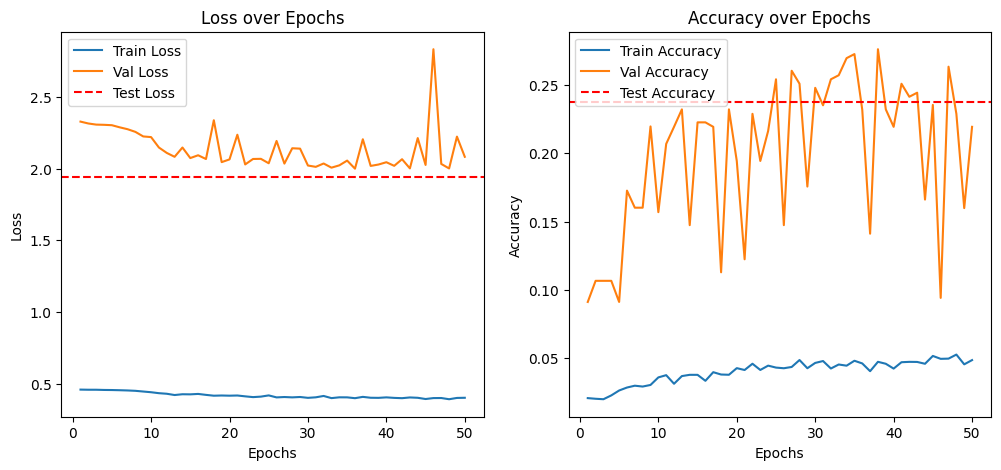

In [9]:
import matplotlib.pyplot as plt
def plot_metrics(train_losses, val_losses, test_loss, train_accuracies, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_loss, val_loss,test_loss, train_acc, val_acc, test_acc)

In [10]:
class CNNet(nn.Module):
  def __init__(self):
    super(CNNet, self).__init__()
    self.layer1=nn.Conv2d(3,128,kernel_size=2)
    self.layer2=nn.Conv2d(128,64,kernel_size=2)
    self.layer3=nn.Conv2d(64,64,kernel_size=2)
    self.layer4=nn.Conv2d(64,32,kernel_size=2)
    self.pooling = nn.MaxPool2d (kernel_size=(2, 2))
    self.lin1 = nn.Linear (32 * 43 * 43, 128,128)
    self.lin2 = nn.Linear (128,10)
    self.relu=nn.ReLU()
  def forward(self,x):
    x=self.layer1(x)
    x=self.relu(x)
    x=self.layer2(x)
    x=self.relu(x)
    x=self.pooling(x)
    x=self.layer3(x)
    x=self.relu(x)
    x=self.layer4(x)
    x=self.relu(x)
    x=self.pooling (x)
    x = x.flatten(start_dim=1)
    x=self.lin1 (x)
    x=self.relu(x)
    x=self.lin2 (x)

    

    return x

In [11]:
experiment_cnn = start(
  api_key="dEZzsaQExxOoLg04pynbidvNw",
  project_name="Deep Learning Technologies",
  workspace="gibranfil"
)
experiment_cnn.set_name ("cnn")


COMET INFO: An experiment with the same configuration options is already running and will be reused.


In [12]:
hyper_param_cnn = {'learning_rate' : 0.01, 'epochs' : 50}
experiment_cnn.log_parameters (hyper_param_cnn)
lr=0.01
epochs=50
model_cnn = CNNet()
loss_fn=nn.CrossEntropyLoss()
running_loss=0.0

In [13]:
with experiment_cnn.train () :
    watch (model_cnn)
    train_loss, val_loss, train_acc, val_acc, test_loss, test_acc= train (model_cnn, experiment_cnn,hyper_param_cnn) 

Epoch 1/50
Train Loss: 0.4573, Train Accuracy: 0.0191
Val Loss: 2.3048, Val Accuracy: 0.0940
Epoch 2/50
Train Loss: 0.4570, Train Accuracy: 0.0188
Val Loss: 2.3046, Val Accuracy: 0.1065
Epoch 3/50
Train Loss: 0.4570, Train Accuracy: 0.0187
Val Loss: 2.3043, Val Accuracy: 0.1065
Epoch 4/50
Train Loss: 0.4569, Train Accuracy: 0.0188
Val Loss: 2.3041, Val Accuracy: 0.1065
Epoch 5/50
Train Loss: 0.4569, Train Accuracy: 0.0205
Val Loss: 2.3039, Val Accuracy: 0.1065
Epoch 6/50
Train Loss: 0.4567, Train Accuracy: 0.0203
Val Loss: 2.3038, Val Accuracy: 0.1190
Epoch 7/50
Train Loss: 0.4567, Train Accuracy: 0.0176
Val Loss: 2.3036, Val Accuracy: 0.1065
Epoch 8/50
Train Loss: 0.4566, Train Accuracy: 0.0203
Val Loss: 2.3034, Val Accuracy: 0.1065
Epoch 9/50
Train Loss: 0.4566, Train Accuracy: 0.0224
Val Loss: 2.3032, Val Accuracy: 0.1065
Epoch 10/50
Train Loss: 0.4565, Train Accuracy: 0.0219
Val Loss: 2.3029, Val Accuracy: 0.1065
Epoch 11/50
Train Loss: 0.4564, Train Accuracy: 0.0228
Val Loss: 2.30

In [ ]:
experiment_cnn.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : cnn
COMET INFO:     url                   : https://www.comet.com/gibranfil/deep-learning-technologies/dcebcacc412247f08b26f03c95cc340b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [110] : (1.450073480606079, 2.336390972137451)
COMET INFO:   Others:
COMET INFO:     Name : cnn
COMET INFO:   Parameters:
COMET INFO:     epochs        : 50
COMET INFO:     learning_rate : 0.01
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     histogram3d         : 36
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook           

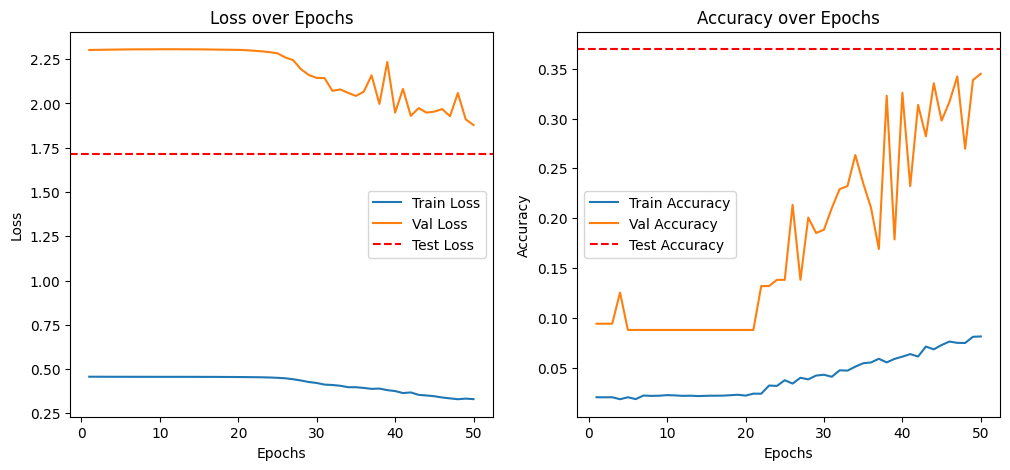

In [ ]:
plot_metrics(train_loss, val_loss,test_loss, train_acc, val_acc, test_acc)